In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import emcee
import corner

In [2]:
%matplotlib notebook

In [3]:
info_path="../../forced_lightcurves/sample_lc_v2/"
salt_df = pd.read_csv(info_path + "../../Nobs_cut_salt2_spec_subtype.csv")

# Prepare light curves for model fitting

This is a playground to develop the function necessary to create light curves for ingestion into the model-fitting procedure designed to determine the time of first light and parameters of the early rise.

In [4]:
rel_flux_cutoff = 0.4
flux_scale = 100
    
for filenum, sn in enumerate(salt_df.name.values):
    lc_df = pd.read_hdf(info_path+"{}_force_phot.h5".format(sn))
    t_max = float(salt_df['t0_g_adopted'][salt_df['name'] == sn].values)
    z = float(salt_df['z_adopt'][salt_df['name'] == sn].values)
    g_max = float(salt_df['fratio_gmax_2adam'][salt_df['name'] == sn].values)
    r_max = float(salt_df['fratio_rmax_2adam'][salt_df['name'] == sn].values)
    g_obs = np.where(lc_df['filter'] == b'g')
    r_obs = np.where(lc_df['filter'] == b'r')
    time_rf = (lc_df['jdobs'].values - t_max)/(1+z)        
    baseline = np.where(time_rf < -20)
    has_baseline = np.ones_like(time_rf).astype(bool)
    fmcmc = lc_df['Fmcmc'].values
    fmcmc_unc = lc_df['Fmcmc_unc'].values
    zp = lc_df.zp.values
    zp_unc = lc_df.ezp.values
    around_peak = np.where(np.abs(time_rf) <=4)
    
    f_zp = np.zeros_like(fmcmc)
    f_zp_unc = np.zeros_like(fmcmc)
    zp_base = np.zeros_like(fmcmc)
    
    for fcqfid in np.unique(lc_df.fcqfid.values):
        this_chip = np.where(lc_df.fcqfid.values == fcqfid)
        this_baseline = np.intersect1d(baseline, this_chip)
        
        if len(this_baseline) >= 1:
            zp_base[this_chip] = np.median(fmcmc[this_baseline]/10**(0.4*zp[this_baseline]))

            f_zp[this_chip] = fmcmc[this_chip]/10**(0.4*zp[this_chip])
            f_zp_unc[this_chip] = np.hypot(fmcmc_unc[this_chip]/10**(0.4*zp[this_chip]), 
                                             np.log(10)/2.5*fmcmc[this_chip]*zp_unc[this_chip]/10**(0.4*zp[this_chip]))
        else:
            has_baseline[this_chip] = 0
            print(sn, fcqfid, np.unique(lc_df.fcqfid.values))
            

    f_zp[g_obs] = f_zp[g_obs]/g_max
    f_zp[r_obs] = f_zp[r_obs]/r_max
    f_zp_unc[g_obs] = f_zp_unc[g_obs]/g_max
    f_zp_unc[r_obs] = f_zp_unc[r_obs]/r_max
    
    cutoff_g = np.where((time_rf[g_obs] < -5) & 
                       (f_zp[g_obs]-zp_base[g_obs]/g_max < rel_flux_cutoff))
    t_cut_g = time_rf[g_obs][cutoff_g[0][-1]] + 0.5
    early_g = np.where(time_rf[g_obs] < t_cut_g)
    cutoff_r = np.where((time_rf[r_obs] < -5) & 
                       (f_zp[r_obs]-zp_base[r_obs]/r_max < rel_flux_cutoff))
    t_cut_r = time_rf[r_obs][cutoff_r[0][-1]] + 0.5
    early_r = np.where(time_rf[r_obs] < t_cut_r)
    early_obs = np.append(g_obs[0][early_g], r_obs[0][early_r])

    return_obs = np.intersect1d(np.where(has_baseline > 0), early_obs)
    not_included = np.setdiff1d(range(len(f_zp)), return_obs)
    
#     time_rf[return_obs], f_zp[return_obs]*flux_scale, f_zp_unc[return_obs]*flux_scale, lc_df.fcqfid.values[return_obs]

ZTF18aauhxce 7541421.0 [7541421. 7541422. 7890331. 7890332.]


In [5]:
def prep_light_curve(lc_hdf,
                     t_max=0, 
                     z=0,
                     g_max=1,
                     r_max=1,
                     rel_flux_cutoff=0.4, 
                     flux_scale = 100,
                     return_masked=False):
    
    # light curve data
    lc_df = pd.read_hdf(lc_hdf)
    g_obs = np.where(lc_df['filter'] == b'g')
    r_obs = np.where(lc_df['filter'] == b'r')
    time_rf = (lc_df['jdobs'].values - t_max)/(1+z)        
    baseline = np.where(time_rf < -20)
    has_baseline = np.ones_like(time_rf).astype(bool)
    fmcmc = lc_df['Fmcmc'].values
    fmcmc_unc = lc_df['Fmcmc_unc'].values
    zp = lc_df.zp.values
    zp_unc = lc_df.ezp.values
    
    f_zp = np.zeros_like(fmcmc)
    f_zp_unc = np.zeros_like(fmcmc)
    zp_base = np.zeros_like(fmcmc)
    
    for fcqfid in np.unique(lc_df.fcqfid.values):
        this_chip = np.where(lc_df.fcqfid.values == fcqfid)
        this_baseline = np.intersect1d(baseline, this_chip)
        
        if len(this_baseline) >= 1:
            zp_base[this_chip] = np.median(fmcmc[this_baseline]/10**(0.4*zp[this_baseline]))

            f_zp[this_chip] = fmcmc[this_chip]/10**(0.4*zp[this_chip])
            f_zp_unc[this_chip] = np.hypot(fmcmc_unc[this_chip]/10**(0.4*zp[this_chip]), 
                                             np.log(10)/2.5*fmcmc[this_chip]*zp_unc[this_chip]/10**(0.4*zp[this_chip]))
        else:
            has_baseline[this_chip] = 0
            print(sn, fcqfid, np.unique(lc_df.fcqfid.values))
            

    f_zp[g_obs] = f_zp[g_obs]/g_max
    f_zp[r_obs] = f_zp[r_obs]/r_max
    f_zp_unc[g_obs] = f_zp_unc[g_obs]/g_max
    f_zp_unc[r_obs] = f_zp_unc[r_obs]/r_max
    
    cutoff_g = np.where((time_rf[g_obs] < -5) & 
                       (f_zp[g_obs]-zp_base[g_obs]/g_max < rel_flux_cutoff))
    t_cut_g = time_rf[g_obs][cutoff_g[0][-1]] + 0.5
    early_g = np.where(time_rf[g_obs] < t_cut_g)
    cutoff_r = np.where((time_rf[r_obs] < -5) & 
                       (f_zp[r_obs]-zp_base[r_obs]/r_max < rel_flux_cutoff))
    t_cut_r = time_rf[r_obs][cutoff_r[0][-1]] + 0.5
    early_r = np.where(time_rf[r_obs] < t_cut_r)
    early_obs = np.append(g_obs[0][early_g], r_obs[0][early_r])

    return_obs = np.intersect1d(np.where(has_baseline > 0), early_obs)
    not_included = np.setdiff1d(range(len(f_zp)), return_obs)    

    if not return_masked:
        return time_rf[return_obs], f_zp[return_obs]*flux_scale, f_zp_unc[return_obs]*flux_scale, lc_df.fcqfid.values[return_obs]
    else:
        return time_rf, f_zp*flux_scale, f_zp_unc*flux_scale, lc_df.fcqfid.values, return_obs

In [11]:
def f_t(times, amplitude=25, t_0=0, alpha_r=2):
    
    return amplitude * (times - t_0)**alpha_r

def plot_both_filt(theta, 
                   t, f, f_unc, fcqfid_arr,
                   obs_for_model,
                   samples, samp_nums
                  ):

    color_dict = {b'r': 'Crimson',
                  b'g': 'MediumAquaMarine'}
    offset_dict = {b'r': -10,
                  b'g': 10}
    mark_color_dict = {b'r': 'white',
                  b'g': 'MediumAquaMarine'}
    sym_dict = {b'r': 'o',
                b'g': 'o'}
    mec_dict = {b'r': 'Crimson',
                b'g': '0.5'}
    mew_dict = {b'r': 2,
                b'g': 0.5}
    filt_dict = {1: b'g', 2: b'r'}
    
    plot_min = 0.0
    res_max = 0.0
    res_min = 0.0

    fig = plt.figure()
    axPlot = plt.axes([0.15, 0.37, 0.82, 0.60])
    axRes = plt.axes([0.15, 0.11, 0.82, 0.25], sharex=axPlot)
    
    n_fcqid = len(np.unique(fcqfid_arr[obs_for_model]))
    n_filt = len(np.unique(np.unique(fcqfid_arr[obs_for_model]) % 10))
    
    if len(theta) != 1 + 2*n_filt + 2*n_fcqid:
        raise RuntimeError('The correct number of parameters were not included')

    for fcqfid_num, fcqfid in enumerate(np.unique(fcqfid_arr[obs_for_model])):
        filt_int = int(fcqfid % 10)
        theta_fcqfid = np.array([theta[0], theta[1 + 2*n_filt + 2*fcqfid_num], 
                                 theta[2*filt_int-1], theta[2*filt_int],
                                 theta[2 + 2*n_filt + 2*fcqfid_num]])
        filt = filt_dict[filt_int]

        fcqfid_obs = np.where(fcqfid_arr == fcqfid)
        f_fcqfid = f[fcqfid_obs]
        t_fcqfid = t[fcqfid_obs]
        f_err_fcqfid = f_unc[fcqfid_obs]        
        
        
        t_post = np.linspace(theta[0], 80, 1000)
        t_pre = np.linspace(min(t_fcqfid), theta[0], 1000)
        model_flux = f_t(t_post, theta_fcqfid[2]*10**(-theta_fcqfid[3]), theta_fcqfid[0], theta_fcqfid[3]) # remove baseline from model
        
        fit_data = np.intersect1d(obs_for_model, fcqfid_obs)
        no_fit = np.setdiff1d(fcqfid_obs, fit_data)
                
        axPlot.errorbar(t[fit_data], f[fit_data] - theta_fcqfid[1] + offset_dict[filt], f_unc[fit_data],
                    fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
                    mec=mec_dict[filt], mew=mew_dict[filt])
        axPlot.errorbar(t[no_fit], f[no_fit] - theta_fcqfid[1] + offset_dict[filt], f_unc[no_fit],
                    fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
                    mec=mec_dict[filt], mew=mew_dict[filt], alpha=0.2)
        
        axPlot.plot(t_post, model_flux + offset_dict[filt], color=color_dict[filt], zorder=10)
        axPlot.plot(t_pre, np.zeros_like(t_pre) + offset_dict[filt], color=color_dict[filt], zorder=10)
        axPlot.set_xlim(-30, 1)
        
        plot_range = np.where((t > -30) & (t < 1) )
        res_range = np.where((t > -30) & (t < np.max(t[fit_data]) ))
        plot_points = np.intersect1d(plot_range, fcqfid_obs)
        res_points = np.intersect1d(res_range, fcqfid_obs)

        if len(plot_points) > 0:
            plot_min = np.min([min(f[plot_points] - theta_fcqfid[1] + offset_dict[filt]), plot_min])
        axPlot.set_ylim(plot_min-5, 110)

        after_exp = t >= theta_fcqfid[0]

        residuals = np.append(f[~after_exp] - theta_fcqfid[1], 
                              f[after_exp] - (theta_fcqfid[1] + f_t(t[after_exp], theta_fcqfid[2]*10**(-theta_fcqfid[3]), theta_fcqfid[0], theta_fcqfid[3]))  
                             )
        # plot residuals
#         axRes.errorbar(t_fcqfid[half_max], residuals[half_max] + offset_dict[filt], f_err_fcqfid[half_max],
#                        fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
#                        mec=mec_dict[filt], mew=mew_dict[filt])
#         axRes.errorbar(t_fcqfid[~half_max], residuals[~half_max] + offset_dict[filt], f_err_fcqfid[~half_max],
#                        fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
#                        mec=mec_dict[filt], mew=mew_dict[filt], alpha=0.2)
#         axRes.plot([-5000,10000], [offset_dict[filt], offset_dict[filt]], '-', color=color_dict[filt])
#         axRes.set_ylim(min(residuals[half_max]) - 0.1, max(residuals[half_max]) + 0.1)

        #plot pull
        axRes.plot(t[fit_data], residuals[fit_data]/(f_unc[fit_data]*theta_fcqfid[4]),
                       sym_dict[filt], color=mark_color_dict[filt], 
                       mec=mec_dict[filt], mew=mew_dict[filt])
        axRes.plot(t[no_fit], residuals[no_fit]/(f_unc[no_fit]*theta_fcqfid[4]),
                       sym_dict[filt], color=mark_color_dict[filt], 
                       mec=mec_dict[filt], mew=mew_dict[filt], alpha=0.2)
        axRes.plot([-5000,10000], [0, 0], '-k')
        if len(res_points) > 0:
            res_min = np.min([min(residuals[res_points]/(f_unc[res_points]*theta_fcqfid[4])), res_min])
            res_max = np.max([max(residuals[res_points]/(f_unc[res_points]*theta_fcqfid[4])), res_max])
        axRes.set_ylim(res_min - 0.2, 
                       res_max + 0.2)

    axPlot.set_ylabel('$f + \mathrm{offset} \; (\mathrm{arbitrary \; units})$', fontsize=14)
    axPlot.xaxis.set_minor_locator(MultipleLocator(1))
    axPlot.yaxis.set_major_locator(MultipleLocator(20))
    axPlot.yaxis.set_minor_locator(MultipleLocator(10))
    axPlot.tick_params(right=True, top=True, bottom=False, which='both', labelsize=11)
    
    axRes.set_xlim(-30, 1)
    axRes.set_xlabel('$t - t_0 \; (\mathrm{restframe \; d})$', fontsize=14)
    axRes.set_ylabel('$\mathrm{pull}$', fontsize=14)
    axRes.xaxis.set_minor_locator(MultipleLocator(1))
    axRes.yaxis.set_minor_locator(MultipleLocator(np.mean(np.diff(axRes.get_yticks()))/2))
    axRes.yaxis.set_major_locator(MultipleLocator(np.mean(np.diff(axRes.get_yticks()))))
    axRes.tick_params(right=True,which='both', labelsize=11)

    # plot up t0
    t0_med = np.median(samples[:,0])
    t0_theta = theta_fcqfid[0]
    axPlot.plot([t0_med,t0_med], [-500,500], 
           '--', color='0.5', lw=1)
    axRes.plot([t0_med,t0_med], [-500,500], 
           '--', color='0.5', lw=1)
    axPlot.plot([t0_theta,t0_theta], [-500,500], 
           '--', color='0.8', lw=0.5)
    axRes.plot([t0_theta,t0_theta], [-500,500], 
           '--', color='0.8', lw=0.5)
    
    for samp_num in samp_nums:
        theta_samp = samples[samp_num]
        for fcqfid_num, fcqfid in enumerate(np.unique(fcqfid_arr[obs_for_model])):
            filt_int = int(fcqfid % 10)
            filt = filt_dict[filt_int]
            theta_fcqfid = np.array([theta_samp[0], theta_samp[1 + 2*n_filt + 2*fcqfid_num], 
                                     theta_samp[2*filt_int-1], theta_samp[2*filt_int],
                                     theta_samp[2 + 2*n_filt + 2*fcqfid_num]])
        
            t_post = np.linspace(theta_fcqfid[0], 80, 1000)
            t_pre = np.linspace(-80, theta_fcqfid[0], 1000)
            model_flux =  f_t(t_post, theta_fcqfid[2]*10**(-theta_fcqfid[3]), theta_fcqfid[0], theta_fcqfid[3])
            axPlot.plot(t_post, model_flux + offset_dict[filt], '--', 
                        color=color_dict[filt], zorder=10,
                        alpha=0.4)
            axPlot.plot(t_pre, np.zeros_like(t_pre) + offset_dict[filt], '--',
                        color=color_dict[filt], zorder=10,
                        alpha=0.4)
    plt.setp(axPlot.get_xticklabels(), visible=False)

    return fig

In [16]:
sn = 'ZTF18aauhxce'

t_max = float(salt_df['t0_g_adopted'][salt_df['name'] == sn].values)
z = float(salt_df['z_adopt'][salt_df['name'] == sn].values)
g_max = float(salt_df['fratio_gmax_2adam'][salt_df['name'] == sn].values)
r_max = float(salt_df['fratio_rmax_2adam'][salt_df['name'] == sn].values)

t_data, f_data, f_unc_data, fcqfid_data, plot_obs = prep_light_curve(info_path+"{}_force_phot.h5".format(sn),
                                                                     t_max=t_max, 
                                                                     z=z,
                                                                     g_max=g_max,
                                                                     r_max=r_max,
                                                                     rel_flux_cutoff=rel_flux_cutoff, 
                                                                     return_masked=True)

h5_file = info_path + 'big_unc/{}_emcee_40_varchange.h5'.format(sn)
reader = emcee.backends.HDFBackend(h5_file)
thin_by = 250
nsteps = thin_by*np.shape(reader.get_chain())[0]
tau = reader.get_autocorr_time(tol=0)
burnin = int(5*np.max(tau))
samples = reader.get_chain(discard=burnin, thin=np.max(int(np.max(tau)), 0), flat=True)
lnpost = reader.get_log_prob(discard=burnin, thin=np.max([int(np.max(tau)), 1]), flat=True)

t0 = np.percentile(samples[:,0], 50)
max_posterior = samples[np.argmax(lnpost)]

ZTF18aauhxce 7541421.0 [7541421. 7541422. 7890331. 7890332.]


In [17]:
max_posterior

array([-1.60928186e+01,  7.43938628e+01,  7.52069059e-01,  5.33454897e+01,
        6.03202152e-01, -3.05542713e-02,  9.30032770e-01,  4.58579010e-01,
        1.02854639e+00, -2.80075615e-01,  8.70113324e-01])

In [18]:
theta=max_posterior

n_fcqid = len(np.unique(fcqfid_data[plot_obs]))
n_filt = len(np.unique(np.unique(fcqfid_data[plot_obs]) % 10))

for fcqfid_num, fcqfid in enumerate(np.unique(fcqfid_data[plot_obs])):
    filt_int = int(fcqfid % 10)
    theta_fcqfid = np.array([theta[0], theta[1 + 2*n_filt + 2*fcqfid_num], 
                             theta[2*filt_int-1], theta[2*filt_int],
                             theta[2 + 2*n_filt + 2*fcqfid_num]])
    print(theta_fcqfid)


[-1.60928186e+01 -3.05542713e-02  5.33454897e+01  6.03202152e-01
  9.30032770e-01]
[-16.09281862   0.45857901  74.39386285   0.75206906   1.02854639]
[-16.09281862  -0.28007562  53.34548972   0.60320215   0.87011332]


<IPython.core.display.Javascript object>


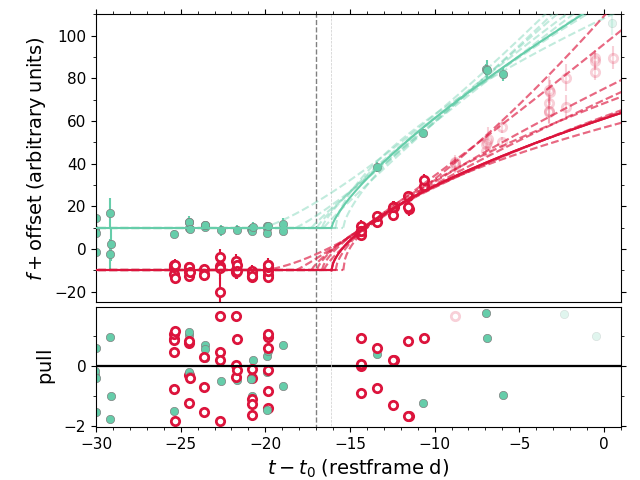

In [19]:
haha = plot_both_filt(max_posterior, t_data, f_data, f_unc_data, fcqfid_data, plot_obs,
                      samples, np.random.choice(range(len(samples)), 8, replace=False))
# haha.savefig('{}_model_lc.png'.format(sn))